# Взять ноутбук colab_text_classification_part1.ipynb который разбирали на занятии и добавить пункты которые мы пропустили

In [1]:
import sys
sys.path.append('../')
from src.text_preprocessor import TextPreprocessor

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from collections import Counter

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers

import nltk

import warnings
warnings.filterwarnings('ignore')

# Base vars and funcs

In [2]:
EPOCHS = 3

eval_df = pd.DataFrame(columns=['vects']).set_index('vects')

In [3]:
def eval_model(model, test_df):
    preds = model.predict(test_df['review'])
    accuracy = accuracy_score(test_df['is_positive'], preds)
    
    result = round(accuracy*100, 2)
    print(f'Test accuracy = {result}%')
    
    return result

def convert(texts, word2idx, max_text_len):
    data = np.zeros((len(texts), max_text_len), dtype=np.int)

    for inx, text in enumerate(texts):
        result = []
        for word in text.split():
            if word in word2idx:
                result.append(word2idx[word])
        padding = [0]*(max_text_len - len(result))
        data[inx] = np.array(padding + result[-max_text_len:], dtype=np.int)

    return data

# Loading data

In [4]:
# Loading data
train_df = pd.read_csv("train.tsv", delimiter="\t")
test_df = pd.read_csv("test.tsv", delimiter="\t")

print(f'Train size = {len(train_df)}')
print(f'Test size = {len(test_df)}')

Train size = 25000
Test size = 25000


## Baseline

<a list of 230 Patch objects>

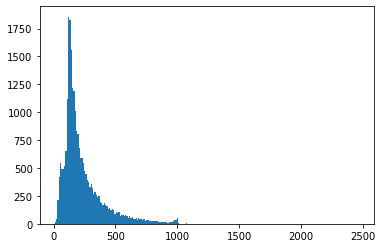

In [5]:
plt.hist(train_df['review'].apply(lambda text: len(text.split())), bins='auto')[2]

In [6]:
words_counter = Counter((word for text in train_df['review'] for word in text.lower().split()))
word2idx = {'':0, '<unk>':1}

for word, count in words_counter.most_common():
    if count < 10:
        break
    word2idx[word] = len(word2idx)

print('Words count', len(word2idx))

X_train = convert(train_df['review'], word2idx, 1000)
X_test = convert(test_df['review'], word2idx, 1000)

Words count 27299


Test accuracy = 86.67%
Test accuracy = 88.31%
Test accuracy = 88.63%
Epoch 1/3
196/196 [==============================] - 25s 127ms/step - loss: 0.6924 - accuracy: 0.5076 - val_loss: 0.6895 - val_accuracy: 0.5141
Epoch 2/3
196/196 [==============================] - 25s 125ms/step - loss: 0.6882 - accuracy: 0.5208 - val_loss: 0.6888 - val_accuracy: 0.5144
Epoch 3/3
782/782 [==============================] - ETA: 0s - loss: 0.6886 - accuracy: 0.51 - 6s 7ms/step - loss: 0.6886 - accuracy: 0.5147


,Baseline
vects,
CV,86.670000
Tfidf,88.310000
Tfidf_1_2,88.630000
W2I,51.466638
mean,78.769159


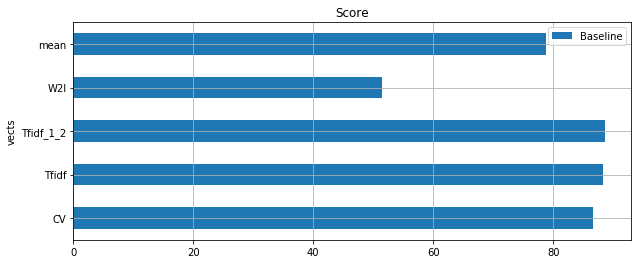

In [7]:
# Logistic Regression
for key, val in {'CV': CountVectorizer(),
                 'Tfidf': TfidfVectorizer(), 
                 'Tfidf_1_2': TfidfVectorizer(ngram_range=(1, 2))}.items():

    model = Pipeline([
        ('vectorizer', val),
        ('classifier', LogisticRegression())
    ])
    model.fit(train_df['review'], train_df['is_positive'])

    eval_df.loc[key, 'Baseline'] = eval_model(model, test_df)

# tensorflow
model = Sequential([
    layers.Embedding(
        input_dim=len(word2idx), 
        output_dim=64, 
        input_shape=(X_train.shape[1],)
    ),
    layers.MaxPooling1D(),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.fit(
    X_train, train_df['is_positive'],
    batch_size=128, epochs=EPOCHS,
    validation_data=(X_test, test_df['is_positive'])
)
eval_df.loc['W2I', 'Baseline'] = model.evaluate(X_test, test_df['is_positive'])[1] * 100
eval_df.loc['mean', 'Baseline'] = eval_df['Baseline'].mean()

# view results
eval_df.plot(kind='barh', grid=True, title='Score', figsize=(10,4))
eval_df

## 4. Поэкспериментируйте с подходом с сеточками на разных данных (с удалёнными сущностями или без)

## 1. Посмотрите на токены если будут мусорные добавьте их в стоп слова и обучите заново

In [8]:
train_df

,is_positive,review
0,0,"Dreamgirls, despite its fistful of Tony wins i..."
1,0,This show comes up with interesting locations ...
2,1,I simply love this movie. I also love the Ramo...
3,0,Spoilers ahead if you want to call them that.....
4,1,My all-time favorite movie! I have seen many m...
...,...,...
24995,1,"I am a big fan of the movie, but not for the u..."
24996,0,I'm not going to bother with a plot synopsis s...
24997,0,This movie . . . I don't know. Why they would ...
24998,1,Saw this film on DVD yesterday and was gob-sma...


# Preprocessing data

In [9]:
train_prep = TextPreprocessor(train_df, 'review')
test_prep = TextPreprocessor(test_df, 'review')

#### train

In [10]:
train_prep.resub_patt('<br />') # Delete tag

# clean trash
train_prep.resub_words('apostrophe')
train_prep.resub_words('emotion')
train_prep.resub_words('short')

train_prep.clean_by_len()
train_prep.clean_stop_words()

# view result
train_df = train_prep.df
train_df[:5]

,is_positive,review
0,0,"Dreamgirls, despite fistful Tony wins incredib..."
1,0,This show comes interesting locations fast tra...
2,1,"simply love movie. also love Ramones, sorta bi..."
3,0,Spoilers ahead want call that...I would almost...
4,1,"My all-time favorite movie! seen many movies, ..."


#### test

In [11]:
test_prep.resub_patt('<br />') # Delete tag

# clean trash
test_prep.resub_words('apostrophe')
test_prep.resub_words('emotion')
test_prep.resub_words('short')

test_prep.clean_by_len()
test_prep.clean_stop_words()

# view result
test_df = test_prep.df
test_df[:5]

,is_positive,review
0,0,formulaic story tired cliches. shocked horribl...
1,1,This entertaining touching version classic tal...
2,0,Corey Haim never going known one great actors ...
3,1,If believe given war movie make really feel wa...
4,1,Carla Gugino literally melts screen crime cape...


# Learning models

<a list of 248 Patch objects>

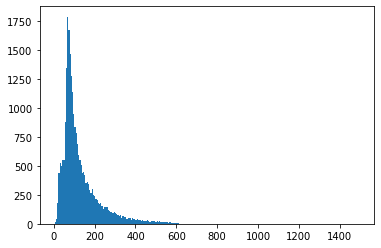

In [12]:
plt.hist(train_df['review'].apply(lambda text: len(text.split())), bins='auto')[2]

In [13]:
words_counter = Counter((word for text in train_df['review'] for word in text.lower().split()))
word2idx = {'':0, '<unk>':1}

for word, count in words_counter.most_common():
    if count < 10:
        break
    word2idx[word] = len(word2idx)

print('Words count', len(word2idx))

X_train = convert(train_df['review'], word2idx, 600)
X_test = convert(test_df['review'], word2idx, 600)

Words count 26252


Test accuracy = 86.42%
Test accuracy = 88.39%
Test accuracy = 88.19%
Epoch 1/3
196/196 [==============================] - 18s 90ms/step - loss: 0.6925 - accuracy: 0.5058 - val_loss: 0.6884 - val_accuracy: 0.5149
Epoch 2/3
196/196 [==============================] - 18s 94ms/step - loss: 0.6867 - accuracy: 0.5140 - val_loss: 0.6871 - val_accuracy: 0.5157
Epoch 3/3
782/782 [==============================] - 4s 5ms/step - loss: 0.6873 - accuracy: 0.5155


,Baseline,TrashOut
vects,,
CV,86.670000,86.420000
Tfidf,88.310000,88.390000
Tfidf_1_2,88.630000,88.190000
W2I,51.466638,51.549131
mean,78.769159,78.637283


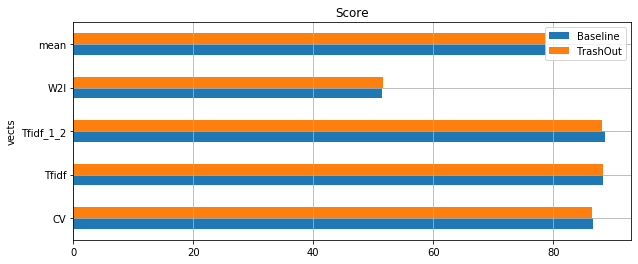

In [14]:
# Logistic Regression
for key, val in {'CV': CountVectorizer(),
                 'Tfidf': TfidfVectorizer(), 
                 'Tfidf_1_2': TfidfVectorizer(ngram_range=(1, 2))}.items():

    model = Pipeline([
        ('vectorizer', val),
        ('classifier', LogisticRegression())
    ])
    model.fit(train_df['review'], train_df['is_positive'])

    eval_df.loc[key, 'TrashOut'] = eval_model(model, test_df)

# tensorflow
model = Sequential([
    layers.Embedding(
        input_dim=len(word2idx), 
        output_dim=64, 
        input_shape=(X_train.shape[1],)
    ),
    layers.MaxPooling1D(),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.fit(
    X_train, train_df['is_positive'],
    batch_size=128, epochs=EPOCHS,
    validation_data=(X_test, test_df['is_positive'])
)
eval_df.loc['W2I', 'TrashOut'] = model.evaluate(X_test, test_df['is_positive'])[1] * 100
eval_df.loc['mean', 'TrashOut'] = eval_df['TrashOut'].mean()

# view results
eval_df.plot(kind='barh', grid=True, title='Score', figsize=(10,4))
eval_df

### вывод:
- после очистки токенов, точность почти не изменилась, однако немного увеличитась скорость

## 2. Проверьте повысилось ли качество на стандартных подходах при лемматизации

In [15]:
train_prep.lemmating()
train_df = train_prep.df

test_prep.lemmating()
test_df = test_prep.df

Test accuracy = 86.25%
Test accuracy = 88.16%
Test accuracy = 88.0%
Epoch 1/3
196/196 [==============================] - 17s 87ms/step - loss: 0.6924 - accuracy: 0.5105 - val_loss: 0.6884 - val_accuracy: 0.5161
Epoch 2/3
196/196 [==============================] - 17s 86ms/step - loss: 0.6868 - accuracy: 0.5160 - val_loss: 0.6870 - val_accuracy: 0.5169
Epoch 3/3
782/782 [==============================] - 4s 5ms/step - loss: 0.6871 - accuracy: 0.5156


,Baseline,TrashOut,Lemmatize
vects,,,
CV,86.670000,86.420000,86.250000
Tfidf,88.310000,88.390000,88.160000
Tfidf_1_2,88.630000,88.190000,88.000000
W2I,51.466638,51.549131,51.562029
mean,78.769159,78.637283,78.493007


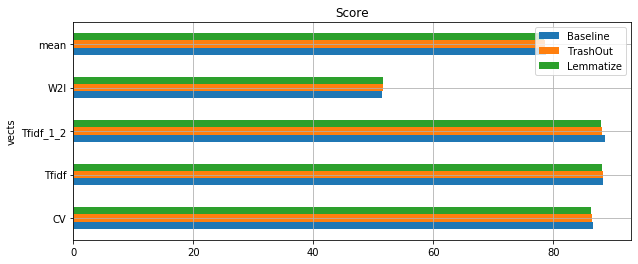

In [16]:
# Logistic Regression
for key, val in {'CV': CountVectorizer(),
                 'Tfidf': TfidfVectorizer(), 
                 'Tfidf_1_2': TfidfVectorizer(ngram_range=(1, 2))}.items():

    model = Pipeline([
        ('vectorizer', val),
        ('classifier', LogisticRegression())
    ])
    model.fit(train_df['review'], train_df['is_positive'])
    
    eval_df.loc[key, 'Lemmatize'] = eval_model(model, test_df)

# tensorflow
model = Sequential([
    layers.Embedding(
        input_dim=len(word2idx), 
        output_dim=64, 
        input_shape=(X_train.shape[1],)
    ),
    layers.MaxPooling1D(),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.fit(
    X_train, train_df['is_positive'],
    batch_size=128, epochs=EPOCHS,
    validation_data=(X_test, test_df['is_positive'])
)
eval_df.loc['W2I', 'Lemmatize'] = model.evaluate(X_test, test_df['is_positive'])[1] * 100
eval_df.loc['mean', 'Lemmatize'] = eval_df['Lemmatize'].mean()

# view results
eval_df.plot(kind='barh', grid=True, title='Score', figsize=(10,4))
eval_df

### вывод
- точность модели при лематизации почти не изменилась

## 3. Удалите из текстов какие-то из сущностей (не удалите а замените их тегом). Запустите классификатор.

In [17]:
for idx, text in enumerate(train_df['review']): # перебираем каждый текст в датасете
    chunks = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(text)))
    names = {' '.join(c[0] for c in chunk) for chunk in chunks if hasattr(chunk, 'label') and chunk.label() == 'PERSON'}
    names = sorted(names, key=len, reverse=True)
    for name in names:
        train_df.loc[idx, 'review'] = re.sub(name, 'PERSON', text)

In [29]:
for idx, text in enumerate(test_df['review']): # перебираем каждый текст в датасете
    chunks = nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(text)))
    names = {' '.join(c[0] for c in chunk) for chunk in chunks if hasattr(chunk, 'label') and chunk.label() == 'PERSON'}
    names = sorted(names, key=len, reverse=True)
    for name in names:
        try:
            test_df.loc[idx, 'review'] = re.sub(name, 'PERSON', text)
        except:
            pass

Test accuracy = 86.52%
Test accuracy = 88.24%
Test accuracy = 88.0%
Epoch 1/5
196/196 [==============================] - 25s 125ms/step - loss: 0.6921 - accuracy: 0.5093 - val_loss: 0.6879 - val_accuracy: 0.5165
Epoch 2/5
196/196 [==============================] - 24s 124ms/step - loss: 0.6860 - accuracy: 0.5186 - val_loss: 0.6870 - val_accuracy: 0.5156
Epoch 3/5
196/196 [==============================] - 24s 122ms/step - loss: 0.6835 - accuracy: 0.5211 - val_loss: 0.6873 - val_accuracy: 0.5155
Epoch 4/5
196/196 [==============================] - 24s 122ms/step - loss: 0.6819 - accuracy: 0.5226 - val_loss: 0.6877 - val_accuracy: 0.5154
Epoch 5/5
782/782 [==============================] - 5s 7ms/step - loss: 0.6883 - accuracy: 0.5150


,Baseline,TrashOut,Lemmatize,Taging
vects,,,,
CV,86.670000,86.420000,86.250000,86.520000
Tfidf,88.310000,88.390000,88.160000,88.240000
Tfidf_1_2,88.630000,88.190000,88.000000,88.000000
W2I,51.466638,51.549131,51.562029,51.500487
mean,78.769159,78.637283,78.493007,78.565122


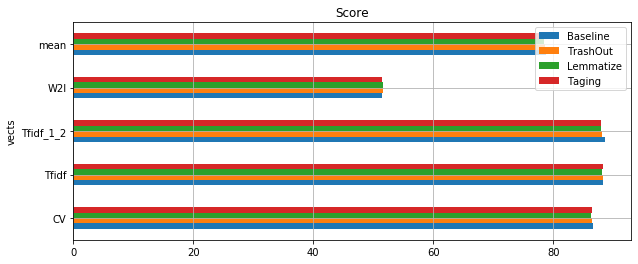

In [30]:
# Logistic Regression
for key, val in {'CV': CountVectorizer(),
                 'Tfidf': TfidfVectorizer(), 
                 'Tfidf_1_2': TfidfVectorizer(ngram_range=(1, 2))}.items():

    model = Pipeline([
        ('vectorizer', val),
        ('classifier', LogisticRegression())
    ])
    model.fit(train_df['review'], train_df['is_positive'])
    
    eval_df.loc[key, 'Taging'] = eval_model(model, test_df)

# tensorflow
model = Sequential([
    layers.Embedding(
        input_dim=len(word2idx), 
        output_dim=64, 
        input_shape=(X_train.shape[1],)
    ),
    layers.MaxPooling1D(),
    layers.Dense(units=10, activation='relu'),
    layers.Dense(units=1, activation='sigmoid')
])
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.fit(
    X_train, train_df['is_positive'],
    batch_size=128, epochs=5,
    validation_data=(X_test, test_df['is_positive'])
)
eval_df.loc['W2I', 'Taging'] = model.evaluate(X_test, test_df['is_positive'])[1] * 100
eval_df.loc['mean', 'Taging'] = eval_df['Taging'].mean()

# view results
eval_df.plot(kind='barh', grid=True, title='Score', figsize=(10,4))
eval_df

### вывод:
- возможно был выбран не самый оптимальный способ перевода ущностей в тег, так как это заняло очень много времени
- точнеость, после данной операции почти не изменилась